# OTSU + HoughCircles (Method 1)

## Quebra dos grupos com hough circles

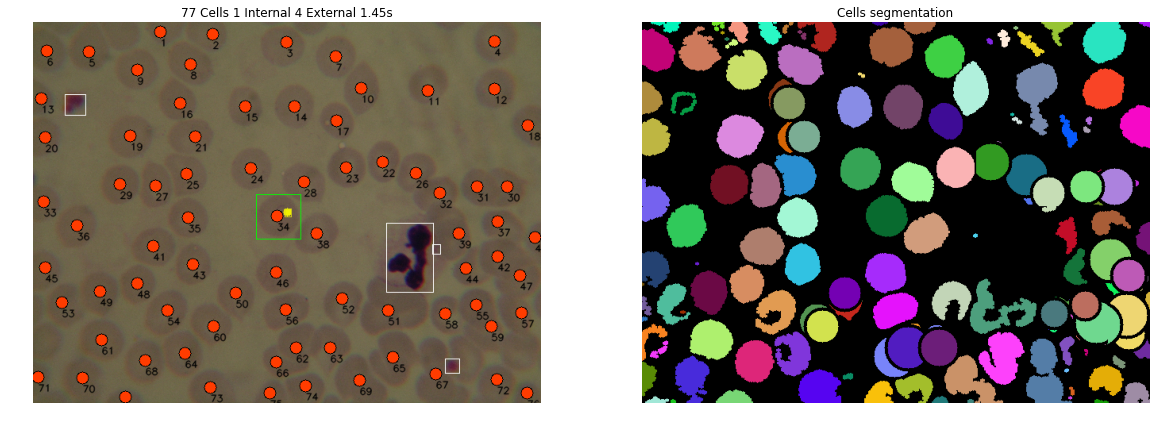

In [1]:
from ipynb.fs.full.general_functions import *

def hough_big_groups(mask,_erode=15,_dilate=11):
    
    labeled_img_rgb, numLabels, labels, stats, centroids = connected_components(mask)

    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        cutY = y - 1 if y > 0 else y
        cutX = x - 1 if x > 0 else x
        cutXW = x+w+1
        cutYH = y+h+1            
            
        cut = mask[cutY:cutYH, cutX:cutXW]

        if MAX_CELL_AREA < area:
            
            cut = cv2.medianBlur(cut, 5)
            #HOUGH, redraw the components
            
            circles = cv2.HoughCircles(cut, cv2.HOUGH_GRADIENT, 
                                        dp=2.8,
                                        minDist=20, 
                                        param1=1, 
                                        param2=31, 
                                        minRadius=18, 
                                        maxRadius=30)
            if circles is not None:
                circles = np.uint16(np.around(circles))
                for i in circles[0, :]:
                    x = int(i[0])
                    y = int(i[1])
                    R = int(i[2])
                    
                    #black border
                    cv2.circle(cut, (x,y), R+2, 0, -1)
                    #white inside
                    cv2.circle(cut, (x,y), R-2, 255, -1)
            
            mask[cutY:cutYH, cutX:cutXW] = cut
    
    return mask

def otsu_hough_method1(path, validation_type, mark_parasites=True):
    """
    Returns: (img, cell_mask_colored), (cells, internal, external, passTime)
    """
    start = time.time()
    #read in grayscale
    imgGS = get_image(path=path)
    #read in colors
    img = get_image(path=path,mode=1)
    
    
    cell_mask = otsu(imgGS)
    #cell_mask = unet.predict(img)

    #hsv mask
    par_mask, par_mask_dilated = hsv_par_mask(img)
    #par_mask = gs_parasite_mask(imgGS)

    #remove parasites from otsu
    cell_mask = remove_parasites(cell_mask,par_mask)

    #fill holes
    cell_mask = fill_holes(cell_mask)

    #break group of cells
    for i in range(10):
        cell_mask = hough_big_groups(cell_mask)
    

    #colorize the cells
    cell_mask_colored = colorize(cell_mask)

    #mark
    img, cells = mark_cells(img, cell_mask,validation_type=validation_type)#,validation_step=False)
    if mark_parasites:
        img, internal, external = parasites_mark(img, par_mask, cell_mask)
    else:
        internal, external = 0,0
        
    end = time.time()


    passTime = "%.2fs" % (end-start)
    
    #save results
    save_results(path, "OTSU + Hough method 1 break",cells,internal,external, passTime, img, "_otsu_hough_1_break", validation_type)
    
    return (img, cell_mask_colored), (cells, internal, external, passTime)


if __name__ == '__main__':
    #PATH = "../PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    #PATH = "../blood_samples/samples/blood_smear_1.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"
    PATH = "../blood_samples/samples/blood_smear_1.JPG"
    images, stats = otsu_hough_method1(PATH, UNET_VALIDATION)
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()